### Deeper Network Analysis 

Now let us extract information from the popular cryptocurrency subreddits to find communities of influencial authors. We offer a list of top subreddits in the field, and then build a graph recursively. 

Code adapted from: https://medium.com/social-media-theories-ethics-and-analytics/network-analysis-from-social-media-data-with-networkx-13605d711590

In [1]:
import praw 
import prawcore
import pandas as pd
import datetime as dt
import networkx as nx
from networkx.algorithms import bipartite
import numpy as np
import requests
import json
import sys
import traceback
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
client_id = "rax4hz8_P0_ttyt8crPYEg"
client_secret = "7zKse44yWl7Dge7kYQV6fKs20IzLdw"
user_agent = "data_analysis_crypto_sentiment v1.0 by /u/K_C_7"

reddit = praw.Reddit(client_id=client_id, client_secret=client_secret, user_agent=user_agent)

Version 7.4.0 of praw is outdated. Version 7.5.0 was released 3 days ago.


In [3]:
popular_crypto_subs = ('bitcoin+'\
                       'btc+'\
                       'CryptoMarkets+'\
                       'bitcoinbeginners+'\
                       'CryptoCurrencies+'\
                       'altcoin+'\
                       'icocrypto+'\
                       'CryptoCurrencyTrading+'\
                       'Crypto_General+'\
                       'ico+'\
                       'blockchain+'\
                       'Best Altcoin Subreddits+'\
                       'ethereum+'\
                       'Ripple+'\
                       'litecoin+'\
                       'Monero+'\
                       'Stellar+'\
                       'binance+'\
                       'CoinBase+'\
                       'ledgerwallet+'\
                       'defi+'\
                       'EthTrader+'\
                       'ethfinance'\
                       'LitecoinTraders')

We now define a recursive function ```recursive_node_adder``` whose inputs are the graph in its current state, a comment and a comment's parent author. The goal is to construct a graph $g$ whose nodes are authors of comments and submissions, and the edges which connect them signify that an author has repsonded to another author's reddit input. In this way, it is sensible to define a <b> directed graph </b>, where now edges have a direction, and if redditor $r$ responds to a comment/submission of redditor $r'$, then $r \to r'$ is a directed link between $r$ and $r'$.

In [9]:
def recursive_node_adder(g, comment, parent_author):
    '''Recursively process comments and add them to the graph g'''    
    if not (comment.author is None):
        # Check if we have the node already in our graph
        if (comment.author not in g.nodes):
            g.add_node(comment.author)
        # Create an edge between this comment author and the parent author
        g.add_edge(comment.author, parent_author)
        # Iterate through the comments
        for reply in comment.replies.list():
            if isinstance(reply, praw.models.MoreComments):
                continue
            if (comment.author is None) or (parent_author is None):
                continue
            # Recursively process this reply
            recursive_node_adder(g, reply, comment.author)

Now we extract the submissions and their metadata from the popular cryptocurrency subreddits over the past month. For the sake of time, we limit the search to the top $n$ submissions where $n$ is given the name ``` limit ``` below. If $n$ is too large during the processing one might interrupt the loop after a large enough number of iterations. 

In [10]:
# Create a DIRECTED graph 
g = nx.DiGraph()
subreddit = popular_crypto_subs
breadthCommentCount = 10

targetSub = reddit.subreddit(subreddit)
submissions = targetSub.top(limit=1000, time_filter='month') #may stop after a significant num of its

i=0

for post in submissions:
    if i%50 == 0:
        print(i)
    #print (post.author, "-", post.title)
    if not (post.author == None):
        # Check if we have the node already in our graph
        if (post.author not in g.nodes):
            g.add_node(post.author)
        post.comment_limit = breadthCommentCount
        # Get the top few comments
        for comment in post.comments.list():
            # Skip MoreComment objects, which don't have authors
            if isinstance(comment, praw.models.MoreComments):
                continue
            # Recursively process this reply
            recursive_node_adder(g, comment, post.author)
    i+=1

0


KeyboardInterrupt: 

In [ ]:
labels = list(g.nodes())
#convert Subreddit instances into their display names for convenience
nodes_new = list(g.nodes()) #initialise
for index, node in enumerate(labels):
    if isinstance(node, str) == False:
        nodes_new[index] = node.name
        
mapping = dict(zip(g.nodes(), nodes_new))        
g = nx.relabel_nodes(g, mapping)

#json storage... could be useful?
from networkx.readwrite import json_graph 
data = json_graph.node_link_data(g)
H = json_graph.node_link_graph(data, directed=True)

In [ ]:
#save the graph
nx.write_gml(g, "/Users/kc/Documents/StatCompVis/CryptoProject/Optimal-Cryptocurrency-Trading-Strategies-Step2/Reddit_Analysis/graph_for_backtesting.gml")

In [ ]:
#export node lists
nodes_list = list(g.nodes())
with open('g_nodes.txt', 'w') as filehandle:
    for node in nodes_list:
        filehandle.write('%s\n' % node)

Okay, so now we can look at the graph and its properties (might be easier in R for plotting/interactivity etc purposes), see R code for this analysis. 

Having done that analysis, one finds that the most influential authors are as follows, (given a certain rationale: will update with this rationale later on).

In [11]:
most_influential_authors = open("most_influential_authors", "r").read()
most_influential_authors = most_influential_authors.split()

In [12]:
most_influential_authors

['naji102',
 'Crypto_Gaming_',
 'simplelifestyle',
 'adamix244',
 'Suthekingg',
 'InevitableComplex895',
 'roymustang261',
 'CoinCorner_Sam',
 'AbsolutBadLad',
 'Imaginary-Adagio2231']

You'll see from the bar charts produced in R and found on the github that many of these names perhaps aren't surprising. However, the order might give you some pause, while not toally shocking. You can see that the detectors of influence contain a wide variety of measures so that one can distinguish these redditors from one another.  

In [4]:
def get_user_posts(user, period, limit):
    redditor = reddit.redditor(user)
    redditor_subs = redditor.submissions.top(period, limit=limit) #get top (limit) submissions from user over the last period 
    posts_info = []
    
    for subm in redditor_subs:
        
        #extract submission information from user
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author)) 
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        subred_info.append(subm.created_utc)
        posts_info.append(subred_info)
        
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'score','upvote_ratio',\
                                                    'num_comments', 'subreddit', "created"])
    return posts_df   


In [5]:
df_naji102 = get_user_posts('naji102', 'year', 250)

In [6]:
df_naji102.head()

,id,author,score,upvote_ratio,num_comments,subreddit,created
0,qqvj8z,naji102,5039,0.92,1010,CryptoCurrency,1.636554e+09
1,kdrb6r,naji102,2010,0.96,150,apexlegends,1.608057e+09
2,qh8zea,naji102,1587,0.97,414,ethtrader,1.635376e+09
3,q6zqpf,naji102,1401,0.98,224,ethtrader,1.634086e+09
4,qpuuq1,naji102,1264,0.97,222,ethtrader,1.636429e+09


In [7]:
df_naji102.shape

(126, 7)

Text(0, 0.5, 'Number of posts')

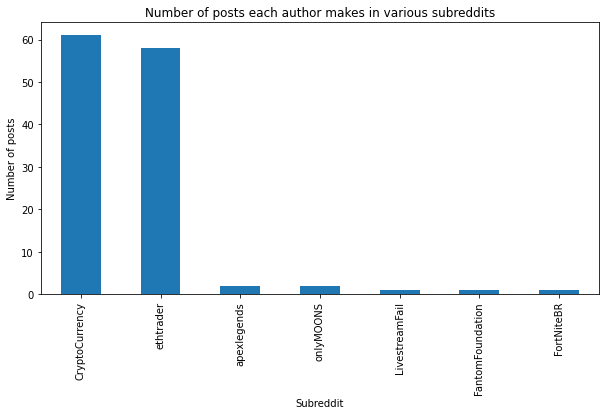

In [8]:
plt.figure(figsize=(10, 5))
ax = df_naji102['subreddit'].value_counts().plot(kind='bar',\
                                                title='Number of posts each author makes in various subreddits')
ax.set_xlabel("Subreddit")
ax.set_ylabel("Number of posts")

So for this guy, it perhaps makes sense to focus on ethereum prices over the past year in analysing the effect of contributions made by naji102. 

In [9]:
from datar.all import f, mutate, tibble, head, tail, arrange


In [10]:
df_naji102 = tibble(df_naji102)
df_naji102_crypto = df_naji102[(df_naji102['subreddit']=="CryptoCurrency") |\
                               (df_naji102['subreddit']=="ethtrader")]

In [11]:
df_naji102_crypto = tibble(df_naji102_crypto)
head(df_naji102_crypto)

,id,author,score,upvote_ratio,num_comments,subreddit,created
,<object>,<object>,<int64>,<float64>,<int64>,<object>,<float64>
0,qqvj8z,naji102,5039,0.92,1010,CryptoCurrency,1.636554e+09
2,qh8zea,naji102,1587,0.97,414,ethtrader,1.635376e+09
3,q6zqpf,naji102,1401,0.98,224,ethtrader,1.634086e+09
4,qpuuq1,naji102,1264,0.97,222,ethtrader,1.636429e+09
5,pskkjj,naji102,1232,0.96,229,ethtrader,1.632237e+09
7,pp9w09,naji102,831,0.86,475,CryptoCurrency,1.631784e+09


In [12]:
df_naji102_crypto = (df_naji102_crypto >> 
                     mutate(created = f.created.astype(int)) >>
                     mutate(created_dt = df_naji102_crypto['created'].apply(lambda time:\
                                                                     dt.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))) >>
                     arrange(f.created_dt) #organise data in chronological order
                    )


In [13]:
head(df_naji102_crypto)

,id,author,score,upvote_ratio,num_comments,subreddit,created,created_dt
,<object>,<object>,<int64>,<float64>,<int64>,<object>,<int64>,<object>
0,p0cj16,naji102,20,0.85,23,ethtrader,1628419659,2021-08-08 12:47:39
1,p0u3mz,naji102,14,0.82,30,CryptoCurrency,1628482641,2021-08-09 06:17:21
2,p0xr63,naji102,7,0.89,7,ethtrader,1628499854,2021-08-09 11:04:14
3,p1sebl,naji102,6,0.88,10,ethtrader,1628611936,2021-08-10 18:12:16
4,p25p4y,naji102,20,0.92,9,ethtrader,1628655425,2021-08-11 06:17:05
5,p2u8nt,naji102,50,0.95,15,ethtrader,1628749699,2021-08-12 08:28:19


In [14]:
tail(df_naji102_crypto)

,id,author,score,upvote_ratio,num_comments,subreddit,created,created_dt
,<object>,<object>,<int64>,<float64>,<int64>,<object>,<int64>,<object>
113,qstdxu,naji102,84,0.93,72,ethtrader,1636778060,2021-11-13 05:34:20
114,qsw2n8,naji102,4,0.70,13,ethtrader,1636788514,2021-11-13 08:28:34
115,qswdl9,naji102,1,1.00,2,ethtrader,1636789843,2021-11-13 08:50:43
116,qt0xmj,naji102,38,0.92,16,ethtrader,1636808926,2021-11-13 14:08:46
117,qt568t,naji102,117,0.97,21,ethtrader,1636822378,2021-11-13 17:52:58
118,qtsmlz,naji102,21,0.89,17,ethtrader,1636905171,2021-11-14 16:52:51


In [15]:
#pd.date_range(start='2021-08-08', end='2021-08-09', freq='H')

In [134]:
from datetime import datetime, timedelta


def round_minutes(time, direction, resolution):
    new_minute = (time.minute // resolution + (1 if direction == 'up' else 0)) * resolution
    return time + timedelta(minutes=new_minute - time.minute)

naji102_posts_nxthr = [round_minutes(time,'up',60).replace(second=0) for time in pd.to_datetime(df_naji102_crypto['created_dt'])]

In [136]:
naji102_posts_nxthr = pd.to_datetime(naji102_posts_nxthr)


In [140]:
naji102_posts_nxthr = pd.DataFrame(naji102_posts_nxthr)
naji102_posts_nxthr

,0
,<datetime64[ns]>
0,2021-08-08 13:00:00
1,2021-08-09 07:00:00
2,2021-08-09 12:00:00
3,2021-08-10 19:00:00
...,...
4,2021-08-11 07:00:00
114,2021-11-13 09:00:00
115,2021-11-13 09:00:00
116,2021-11-13 15:00:00


In [141]:
naji102_posts_nxthr.to_csv("naji102_posts_nxthr.csv")

In [67]:
import csv

In [164]:
eth_hr_imp_w_signal = open("/Users/kc/Documents/StatCompVis/CryptoProject/Optimal-Cryptocurrency-Trading-Strategies-Step2/Reddit_Analysis/Price_Data_Extraction/Data/Binance_OHLC/ETHUSDT-1h-binance-imputed.csv", "r")
eth_hr_imp_w_signal = pd.read_csv(eth_hr_imp_w_signal)

Backtesting via PnL

In [168]:
def get_pnl(prices_data_with_signal, start=1000):    
    #extract closing prices and signal
    signal = prices_data_with_signal['signal']
    close = prices_data_with_signal['close']
    
    start = start
    pnl = [start]
    i = 0
    for index in range(i + 1, len(close)):
        if signal[i] == 1:
            pnl.append(pnl[-1]*close[i+1]/close[i])
        else:
            pnl.append(pnl[-1])
        i += 1
    return pnl

In [169]:
pnl = get_pnl(eth_hr_imp_w_signal)

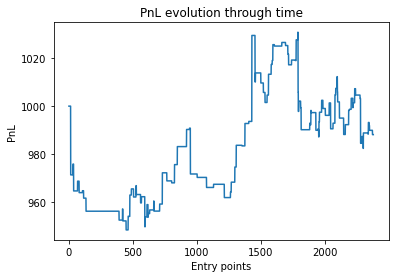

In [170]:
plt.plot(pnl)
plt.xlabel('Entry points')
plt.ylabel('PnL')
plt.title('PnL evolution through time')
plt.show()

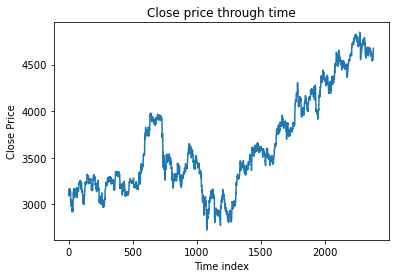

In [171]:
plt.plot(eth_hr_imp_w_signal['close'])            
plt.xlabel('Time index')
plt.ylabel('Close Price')
plt.title('Close price through time')
plt.show() 

#### Minute data 

In [175]:
naji102_posts_nxtmin = [round_minutes(time,'up',1).replace(second=0) for time in pd.to_datetime(df_naji102_crypto['created_dt'])]

In [177]:
pd.DataFrame(naji102_posts_nxthr).to_csv("naji102_posts_nxtmin.csv")

In [ ]:
eth_naji102_m = open("/Users/kc/Documents/StatCompVis/CryptoProject/Optimal-Cryptocurrency-Trading-Strategies-Step2/Reddit_Analysis/Price_Data_Extraction/Data/Binance_OHLC/ETHUSDT-1m-binance-imputed.csv", "r")
eth_naji102_m = pd.read_csv(eth_naji102_m)
head(eth_naji102_m)

In [180]:
pnl_minute = get_pnl(eth_naji102_m)

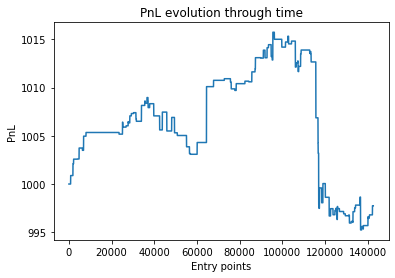

In [182]:
plt.plot(pnl_minute)
plt.xlabel('Entry points')
plt.ylabel('PnL')
plt.title('PnL evolution through time')
plt.show()

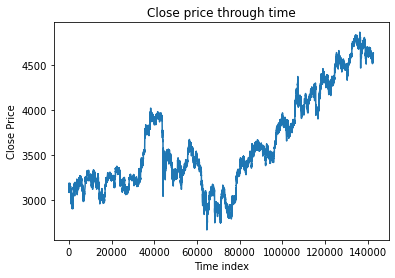

In [183]:
plt.plot(eth_naji102_m['close'])            
plt.xlabel('Time index')
plt.ylabel('Close Price')
plt.title('Close price through time')
plt.show() 